# 概要

因果グラフ（DAG）を用いて、selection on observableの仮定を置いて因果推論する場合、欠落変数バイアスが起きないように適切なDAGを設定する必要がある。

通常、DAGはドメイン知識に基づいて作られるが、データにもとづいてDAGを推定しようとするのが因果探索（causal discovery）の分野。

## Causal Assumptions

[[2303.15027] A Survey on Causal Discovery Methods for I.I.D. and Time Series Data](https://arxiv.org/abs/2303.15027)

グラフィカルモデルで因果探索するための仮定

1. 因果マルコフ条件（Causal Markov Condition）
2. 忠実性（Faithfulness）
3. 因果的十分性（Causal Sufficiency）
4. 非巡回性（Acyclicity）


### 仮定(1)：因果マルコフ条件（Causal Markov Condition）

各ノード$X_i \in X$が親ノードで条件づけられた場合、非子孫ノードとは条件付き独立の関係にある。


例：連鎖構造
- グラフ： $X \to Y \to Z$
- このとき： $Z \perp X \mid Y$（$Y$ を条件づけると $X$ と $Z$ は独立）


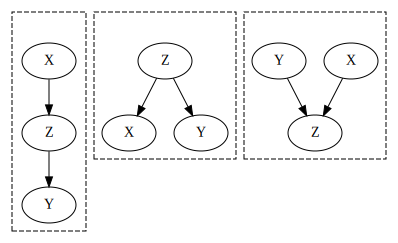

In [7]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;

  subgraph cluster_chain {
    label="連鎖経路";
    style=dashed;
    X1 [label="X"];
    Z1 [label="Z"];
    Y1 [label="Y"];
    X1 -> Z1 -> Y1;
  }

  subgraph cluster_fork {
    label="分岐経路";
    style=dashed;
    Z2 [label="Z"];
    X2 [label="X"];
    Y2 [label="Y"];
    Z2 -> X2;
    Z2 -> Y2;
  }

  subgraph cluster_collider {
    label="合流経路";
    style=dashed;
    X3 [label="X"];
    Y3 [label="Y"];
    Z3 [label="Z"];
    X3 -> Z3;
    Y3 -> Z3;
  }
}
""")

### 仮定(2)：忠実性（Faithfulness）

d分離（d-separation、ノード$X, Y$を別のノード集合$\mathcal{S}$でブロックしている状態） 以外に統計的独立（$Cov(X, Y) = 0$） が成り立たないことを **忠実性** という。


忠実性が満たされない例は次の画像のようなグラフ。$X_3$に対して$X_1 \to X_3$と$X_2 \to X_3$の2つの影響が加わるため、両者の効果が相殺されて$X_2 \to X_3$が見かけ上独立になることが考えられる。

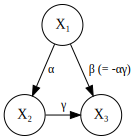

In [6]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 [label="X₁"];
  X2 [label="X₂"];
  X3 [label="X₃"];

  // rank same 指定
  { rank = same; X2; X3; }

  // edges with labels
  X1 -> X2 [label="α", fontsize=12];
  X2 -> X3 [label="γ", fontsize=12];
  X1 -> X3 [label="β (= -αγ)", fontsize=12];
}
""")

### 仮定(3)：因果的十分性（Causal Sufficiency）

未観測の交絡因子が存在しないという仮定。

### 仮定(4)：非巡回性（Acyclicity）

DAGであるという仮定。

## 因果探索手法の分類

主に4つのアプローチがある

1. 制約ベース
2. スコアベース
3. 関数因果モデル
4. 勾配ベースモデル

|        | **① 制約ベース** | **② スコアベース** | **③ 関数因果モデル**（非ガウス性・非線形性の活用） | **④ 勾配ベース** |
|--------|------------------|---------------------|---------------------------------------------------------|------------------|
| **静的** | PC, FCI, RFCI | GES, TTPM, BIC-GES | LiNGAM, PNL, ANM, HPCI, NICA-LiNGAM                   | NOTEARS, NOTEARS-GOLEM, GAE, CORL |
| **動的** | PCMCI, PCMCI+  | SVAR-FCI, tsGES     | VAR-LiNGAM, TiMINo, DAG-GNN (time series version)      | Dynotears, cNOTEARS |




## LiNGAM

**LiNGAM（Linear Non-Gaussian Acyclic Model）** は因果探索の代表的な手法で、

- 構造方程式モデル（線形モデル）で
- 誤差項が非ガウスに従う
- 非巡回（Acyclic）グラフを推定する

といった前提をおく手法（[Shimizu et al., 2006](https://www.cs.helsinki.fi/group/neuroinf/lingam/JMLR06.pdf)）


### モデルの例

モデルは構造方程式で記述される。まずOutcomeもTreatmentもCovariatesも全部$x_i$で表現する。

outcomeを$x_3$とし、$x_1, x_2$をTreatmentとする。

$$
\begin{aligned}
& x_1= e_1 \\
& x_2=b_{21} x_1 + e_2 \\
& x_3=b_{31} x_1 + b_{32} x_2+ e_3
\end{aligned}
$$

この構造方程式モデルを行列表記にすると

$$
\left(\begin{array}{l}
x_1 \\
x_2 \\
x_3
\end{array}\right)=\left(\begin{array}{ccc}
0 & 0 & 0 \\
b_{21} & 0 & 0 \\
b_{31} & b_{32} & 0
\end{array}\right)\left(\begin{array}{l}
x_1 \\
x_2 \\
x_3
\end{array}\right)+\left(\begin{array}{l}
e_1 \\
e_2 \\
e_3
\end{array}\right)
$$

となる。係数行列を$B$とおき、それ以外もベクトルにすると

$$
\boldsymbol{x}
= B \boldsymbol{x}
 + \boldsymbol{e}
$$

となる。


※非巡回の制約があるため、因果の流れの通りに（最上流を$x_1$、最下流を$x_3$に）変数を並べると係数行列$B$が下三角行列になる

### 係数行列の推定

#### モデルの変形

$$
\boldsymbol{x}
= B \boldsymbol{x}
 + \boldsymbol{e}
$$

を変形すると

$$
\begin{align}
\boldsymbol{x} &= B \boldsymbol{x}  + \boldsymbol{e}\\
\boldsymbol{x} (I - B) &= \boldsymbol{e}\\
\boldsymbol{x} &= (I - B)^{-1} \boldsymbol{e}\\
\end{align}
$$

（ここで$I$は単位行列）

$A := (I - B)^{-1}$とすると

$$
\boldsymbol{x} = A \boldsymbol{e}
$$

この$A$を求めれば良い。

$A$の推定では独立成分分析を使用する。


#### 独立成分分析

主成分分析はもとのデータを各変数の相関が0になるような新しい変数に変換する手法。

ガウス分布に従うデータなら、主成分分析で変数間の関係が独立になる。

非ガウス分布に従うデータだと相関は0になるが独立にはならない

独立成分分析は主成分分析の結果$x_{pca}$に対して線形変換を施して新たな変数$x_{ica}$を作成する。

$$
x = A_{ica} x_{ica}
$$

という分解ができるため、LiNGAMではこれを使う。

ただし、$B$が下三角行列なので、$A^{-1}$は対角成分が1で、対角成分より上側のすべての要素が0である必要があり、独立成分分析の後にそうした後処理が必要になる

### LiNGAMの計算手順

※ 小川(2020)と同じように実装したはずだが、一部符号が反転してて、あまりうまくいかなかった

適当にデータを生成する

$$
\begin{aligned}
& x_1= e_1 \\
& x_2= 3 x_1 + e_2 \\
& x_3= 4 x_1 + 5 x_2+ e_3
\end{aligned}
$$


In [114]:
# 適当にデータを生成する
import numpy as np
import pandas as pd

n = 1000
np.random.seed(0)

# 非ガウスの誤差
e1 = np.random.uniform(size=n)
e2 = np.random.uniform(size=n)
e3 = np.random.uniform(size=n)

# 各変数の生成
x1 = e1
x2 = 3*x1 + e2
x3 = 4*x1 + 5*x2 + e3

# DFにする
df = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3})

続いて、独立成分分析を行う

In [115]:
from sklearn.decomposition import FastICA
ica = FastICA(random_state=0, max_iter=10000).fit(df)

# ICAで求めた行列A
A_ica = ica.mixing_
A_ica_inv = np.linalg.inv(A_ica)

A_ica_inv.round(1)

array([[ 13.8,  17.5,  -3.5],
       [  2.9,  -0.7,   0.1],
       [-10.1,   3.3,   0. ]])

続いて、$A_{ica}^{-1}$に対して

1. 行の順番を変換
2. 行の大きさを調整

して対角成分が1で対角成分より上側の要素が全部0な行列になるようにする

munkresパッケージのハンガリアンアルゴリズムという対角成分の和を最小にする問題を解く

:::{margin}
[munkres · PyPI](https://pypi.org/project/munkres/)
:::

In [117]:
# 1. 行の順番を変換
# 絶対値の逆数にして、対角成分の和を最小化する問題に置き換える
A_ica_inv_small = 1 / np.abs(A_ica_inv)

# 対角成分の和を最小にする行の入れ替えを行う
from munkres import Munkres
m = Munkres()
ixs = np.vstack(m.compute(A_ica_inv_small))

# 順番の入れ替え
ixs = ixs[np.argsort(ixs[:, 0]), :]
ixs_perm = ixs[:, 1]
A_ica_inv_perm = np.zeros_like(A_ica_inv)
A_ica_inv_perm[ixs_perm] = A_ica_inv

# 2. 行の大きさを調整
# 対角成分が1になるよう調整
A_ica_inv_perm_adjusted = A_ica_inv_perm / np.diag(A_ica_inv_perm)

A_ica_inv_perm_adjusted.round(1)

array([[ 1. , -0.2, -0. ],
       [-3.5,  1. , -0. ],
       [ 4.8,  5.3,  1. ]])

$A^{-1} = I - B$なので$B= I - A^{-1}$として$B$を求める

In [93]:
I = np.eye(3)
B = I - A_ica_inv_perm_adjusted

B.round(1)

array([[ 0. ,  0.2,  0. ],
       [ 3.5,  0. ,  0. ],
       [-4.8, -5.3,  0. ]])

### lingamパッケージで実践

Pythonだと[lingam](https://pypi.org/project/lingam/)パッケージがある

Tutorial: [DirectLiNGAM — LiNGAM 1.8.2 documentation](https://lingam.readthedocs.io/en/latest/tutorial/lingam.html#directlingam)

In [118]:
import lingam

model = lingam.DirectLiNGAM()
model.fit(df)

# adjacency_matrix_ で推定した係数行列Bを見ることができる
print(model.adjacency_matrix_.round(1))

[[0.  0.  0. ]
 [3.  0.  0. ]
 [3.9 5.  0. ]]


## 参考文献

- [Shimizu, S., Hoyer, P. O., Hyvärinen, A., Kerminen, A., & Jordan, M. (2006). A linear non-Gaussian acyclic model for causal discovery. Journal of Machine Learning Research, 7(10).](https://www.cs.helsinki.fi/group/neuroinf/lingam/JMLR06.pdf)
- [LiNGAM for causal discovery](https://sites.google.com/view/sshimizu06/lingam)（清水ラボ）
- [LiNGAMモデルの推定方法について #Python - Qiita](https://qiita.com/m__k/items/bd87c063a7496897ba7c#fastica)
- 小川雄太郎. (2020). つくりながら学ぶ! Python による因果分析. マイナビ出版.
- 清水昌平（2017）統計的因果探索
- [LiNGAMによる因果探索（基本編） — ごちきか](https://gochikika.ntt.com/Modeling/causal_LiNGAM.html)
    - NTTコミュニケーションズの教材。理論面含めて詳しい話がある